In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
raw_url = "https://raw.githubusercontent.com/cyrusluong1115/databootcamp/refs/heads/main/county_statistics.csv"
df = pd.read_csv(raw_url)
df.drop("Unnamed: 0",axis=1,inplace = True)
# df.dropna(inplace=True)
deaths_per_cap = []
cases_per_cap = []
mortality = []
# adding some extra stats that are useful
for i in range(len(df["deaths"])):
  deaths_per_cap.append(df["deaths"][i] / df["TotalPop"][i])
  cases_per_cap.append(df["cases"][i] / df["TotalPop"][i])
  mortality.append(df["deaths"][i] / df["cases"][i])
df["deaths_per_cap"] = deaths_per_cap
df["cases_per_cap"] = cases_per_cap
df["mortality"] = mortality
df.head()
trump_swing = []
# Calculate % swing between 2016-2020 election
for i in range(len(df["percentage20_Donald_Trump"])):
  # knocking out outliers- data seems funky
  swing = ((df["percentage20_Joe_Biden"][i] - df["percentage16_Hillary_Clinton"][i]) - (df["percentage20_Donald_Trump"][i] - df["percentage16_Donald_Trump"][i]))
  if swing > 0.5:
    swing = 0.5
  if swing < -0.5:
    swing = -0.5
  # if swing > 0:
  #   trump_swing.append(1)
  # else:
  #   trump_swing.append(0)
  trump_swing.append(swing)
df["trump_swing"] = trump_swing
swing_no_outliers = df.loc[(df["trump_swing"] < 0.15) & (df["trump_swing"] > -0.15)]
df.head()

<ipython-input-173-dd670aa247a7>:12: RuntimeWarning: invalid value encountered in scalar divide
  mortality.append(df["deaths"][i] / df["cases"][i])
<ipython-input-173-dd670aa247a7>:12: RuntimeWarning: divide by zero encountered in scalar divide
  mortality.append(df["deaths"][i] / df["cases"][i])


,county,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,deaths_per_cap,cases_per_cap,mortality,trump_swing
0,Abbeville,SC,0.629,0.346,10724.0,6742.0,3712.0,0.661,0.330,12433.0,...,9505.0,78.8,13.3,7.8,0.1,9.4,0.000686,0.032475,0.021118,-0.048
1,Acadia,LA,0.773,0.206,27386.0,21159.0,5638.0,0.795,0.191,28425.0,...,24982.0,80.0,12.1,7.6,0.3,8.9,0.001629,0.050825,0.032055,-0.037
2,Accomack,VA,0.545,0.428,15755.0,8582.0,6737.0,0.542,0.447,16938.0,...,13837.0,74.6,18.1,7.1,0.2,5.4,0.000579,0.037363,0.015485,0.022
3,Ada,ID,0.479,0.387,195587.0,93748.0,75676.0,0.504,0.465,259389.0,...,214984.0,78.3,15.0,6.6,0.1,4.3,0.000416,0.040106,0.010372,0.053
4,Adair,IA,0.653,0.300,3759.0,2456.0,1127.0,0.697,0.286,4183.0,...,3680.0,73.8,15.3,10.4,0.5,3.0,0.000139,0.030868,0.004505,-0.058


In [ ]:
corr_filter = df.corr(numeric_only = True)[["trump_swing"]].sort_values(by = "trump_swing", ascending = False)
corr_filter = corr_filter.loc[corr_filter["trump_swing"] > 0.15]
swing_vars = corr_filter.index.tolist()
swing_vars.remove("trump_swing")
# swing_vars.remove("linreg_preds")
swing_vars
corr_filter = df.corr(numeric_only = True)[["trump_swing"]].sort_values(by = "trump_swing", ascending = True)
corr_filter = corr_filter.loc[corr_filter["trump_swing"] < -0.15]
swing_vars += corr_filter.index.tolist()
vars_len = len(swing_vars)
swing_vars

['Professional',
 'IncomePerCap',
 'Income',
 'percentage20_Joe_Biden',
 'votes16_Donald_Trump',
 'Asian',
 'Office',
 'votes20_Donald_Trump',
 'total_votes16',
 'lat',
 'Production',
 'Construction',
 'percentage20_Donald_Trump',
 'ChildPoverty',
 'Poverty',
 'Hispanic',
 'IncomeErr',
 'deaths_per_cap']

In [ ]:
df.dropna(inplace=True)
#select columns with highest absolute value of correlation with trump_swing
X = df[swing_vars]
y = df["trump_swing"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3021 entries, 0 to 3110
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Professional               3021 non-null   float64
 1   IncomePerCap               3021 non-null   float64
 2   Income                     3021 non-null   float64
 3   percentage20_Joe_Biden     3021 non-null   float64
 4   votes16_Donald_Trump       3021 non-null   float64
 5   Asian                      3021 non-null   float64
 6   Office                     3021 non-null   float64
 7   votes20_Donald_Trump       3021 non-null   float64
 8   total_votes16              3021 non-null   float64
 9   lat                        3021 non-null   float64
 10  Production                 3021 non-null   float64
 11  Construction               3021 non-null   float64
 12  percentage20_Donald_Trump  3021 non-null   float64
 13  ChildPoverty               3021 non-null   float64
 1

In [ ]:
y.info()

<class 'pandas.core.series.Series'>
Index: 3021 entries, 0 to 3110
Series name: trump_swing
Non-Null Count  Dtype  
--------------  -----  
3021 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


In [ ]:
zeroes_list = [0.0] * len(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
zeroes_test = [0.0] * len(y_test)
X_train

,Professional,IncomePerCap,Income,percentage20_Joe_Biden,votes16_Donald_Trump,Asian,Office,votes20_Donald_Trump,total_votes16,lat,Production,Construction,percentage20_Donald_Trump,ChildPoverty,Poverty,Hispanic,IncomeErr,deaths_per_cap
797,36.5,27317.0,58685.0,0.438,34932.0,1.9,25.7,41913.0,62463.0,33.079437,11.5,9.3,0.542,16.2,11.8,5.0,1583.0,0.000672
2608,28.3,23877.0,46132.0,0.213,27347.0,0.4,20.8,31105.0,35730.0,39.971727,18.7,12.6,0.776,20.6,12.7,1.4,1176.0,0.000040
732,29.5,27866.0,55411.0,0.272,5072.0,0.1,25.0,5623.0,7469.0,40.175145,16.2,11.6,0.703,21.3,13.3,2.6,3084.0,0.000371
522,27.2,27719.0,54882.0,0.540,319571.0,9.5,26.1,402271.0,765421.0,36.214589,9.6,7.9,0.440,21.2,14.6,30.7,434.0,0.000718
197,24.4,20911.0,43404.0,0.207,6733.0,0.0,19.7,7508.0,8748.0,32.996421,22.4,15.9,0.784,26.6,15.2,2.4,3431.0,0.000664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,33.4,27318.0,53693.0,0.342,21935.0,0.7,23.9,23734.0,36598.0,43.154944,16.5,10.7,0.634,16.9,11.7,4.2,1648.0,0.000055
1574,23.3,21879.0,41720.0,0.206,4799.0,0.3,18.3,5685.0,6367.0,37.545671,29.5,15.0,0.779,23.0,15.8,3.2,4427.0,0.000071
3075,32.4,22961.0,48214.0,0.194,808.0,0.3,19.7,877.0,1046.0,40.479456,15.5,12.7,0.792,23.3,15.0,1.2,3659.0,0.000000
994,28.6,22656.0,58167.0,0.096,3907.0,0.5,18.6,5323.0,4609.0,32.740553,16.1,24.9,0.893,11.6,11.0,40.6,5868.0,0.000603


In [ ]:
#Linear Regression
scaler = StandardScaler()
pipe = Pipeline([("poly_features", PolynomialFeatures(degree = 1, include_bias = False)),("scaler", scaler), ("regressor", LinearRegression())])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
preds = pipe.predict(X)
df["linreg_preds"] = preds
df.head()

,county,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,...,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,deaths_per_cap,cases_per_cap,mortality,trump_swing,linreg_preds
0,Abbeville,SC,0.629,0.346,10724.0,6742.0,3712.0,0.661,0.330,12433.0,...,78.8,13.3,7.8,0.1,9.4,0.000686,0.032475,0.021118,-0.048,-0.020283
1,Acadia,LA,0.773,0.206,27386.0,21159.0,5638.0,0.795,0.191,28425.0,...,80.0,12.1,7.6,0.3,8.9,0.001629,0.050825,0.032055,-0.037,-0.015398
2,Accomack,VA,0.545,0.428,15755.0,8582.0,6737.0,0.542,0.447,16938.0,...,74.6,18.1,7.1,0.2,5.4,0.000579,0.037363,0.015485,0.022,0.001814
3,Ada,ID,0.479,0.387,195587.0,93748.0,75676.0,0.504,0.465,259389.0,...,78.3,15.0,6.6,0.1,4.3,0.000416,0.040106,0.010372,0.053,0.047099
4,Adair,IA,0.653,0.300,3759.0,2456.0,1127.0,0.697,0.286,4183.0,...,73.8,15.3,10.4,0.5,3.0,0.000139,0.030868,0.004505,-0.058,0.005130


In [ ]:
pipe.named_steps["poly_features"].get_feature_names_out()
coefs = pipe.named_steps["regressor"].coef_
coef_df = pd.DataFrame(coefs, index = pipe.named_steps["poly_features"].get_feature_names_out(), columns = ["coef"])
coef_df.sort_values(by = "coef", ascending = False)

,coef
votes16_Donald_Trump,0.052445
percentage20_Joe_Biden,0.018654
Income,0.008377
Professional,0.008187
percentage20_Donald_Trump,0.007499
ChildPoverty,0.005647
Construction,0.004681
Office,0.003472
lat,0.000521
IncomePerCap,-0.000053


In [ ]:
print(df["trump_swing"].mean())
print(df["linreg_preds"].mean())
print(f"swing min: {df['trump_swing'].min()}")
print(f"swing max: {df['trump_swing'].max()}")
print(f"linreg min: {df['linreg_preds'].min()}")
print(f"linreg max: {df['linreg_preds'].max()}")
print(f"LinReg Test MSE: {mse(y_test,y_pred)}")
print(f"LinReg MSE: {mse(y,preds)}")
print(f"Baseline Test: {mse(y_test, zeroes_test)}")
print(f"Baseline: {mse(y, zeroes_list)}")

-0.0013518702416418411
-0.0020249923391994825
swing min: -0.5
swing max: 0.5
linreg min: -0.42976973200004887
linreg max: 0.16690237965397556
LinReg Test MSE: 0.002811195345673503
LinReg MSE: 0.002563274649207847
Baseline Test: 0.0036911919258769037
Baseline: 0.0036586249586229727


In [ ]:
continental_us = df.loc[(df["state"] != "HI") & (df["state"] != "AK")& (df["long"] != 0)]

(np.float64(-126.98373933799999),
 np.float64(-64.80167790200001),
 np.float64(24.0283850785),
 np.float64(50.002941411500004))

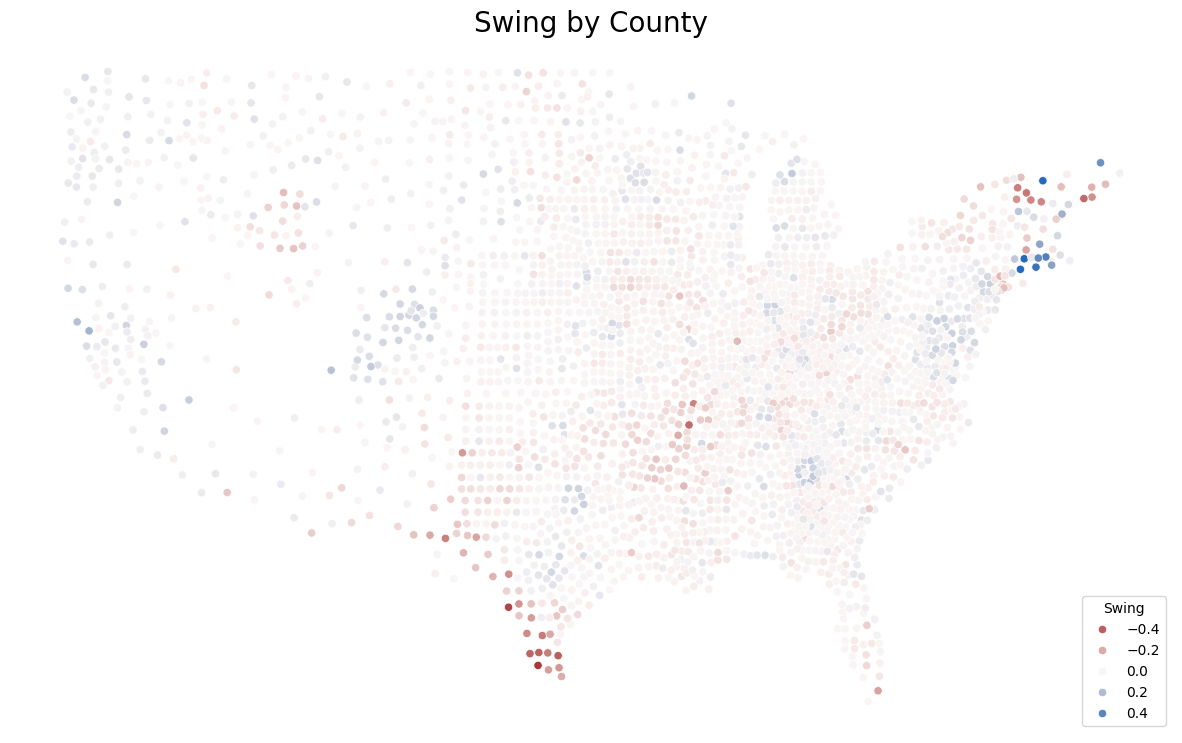

In [ ]:
plt.figure(figsize = (15,9))
sns.scatterplot(data = continental_us, y = "lat",x = "long", hue = "trump_swing",palette = "vlag_r")
plt.legend(title = "Swing", loc = "lower right")
plt.title("Swing by County",fontsize = 20)
plt.axis("off")
#Not included in writeup

(np.float64(-126.98373933799999),
 np.float64(-64.80167790200001),
 np.float64(24.0283850785),
 np.float64(50.002941411500004))

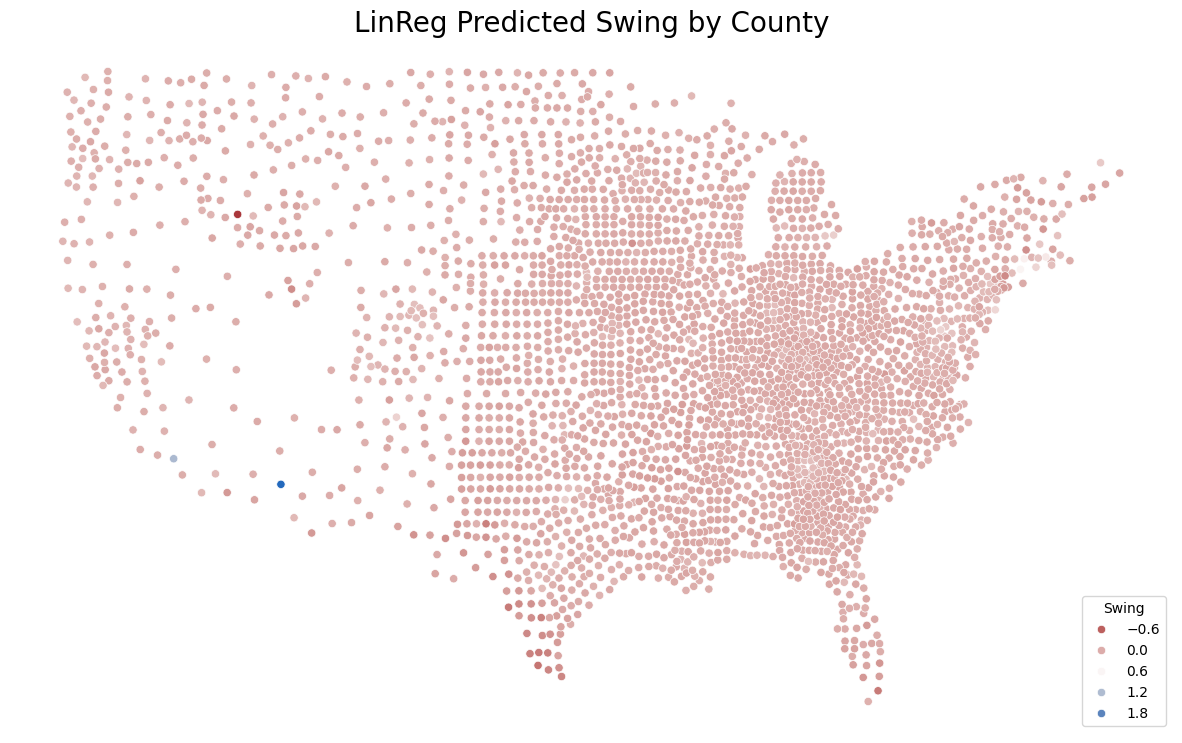

In [ ]:
plt.figure(figsize = (15,9))
sns.scatterplot(data = continental_us, y = "lat",x = "long", hue = "linreg_preds",palette = "vlag_r")
plt.legend(title = "Swing", loc = "lower right")
plt.title("LinReg Predicted Swing by County",fontsize = 20)
plt.axis("off")
#Not included in writeup

In [ ]:
#KNN
knn_pipe = Pipeline([("scaler", scaler), ("knn", KNeighborsRegressor(n_neighbors=3))])
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
knn_preds = knn_pipe.predict(X)
df["knn_preds"] = knn_preds
df.head()

,county,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,...,PublicWork,SelfEmployed,FamilyWork,Unemployment,deaths_per_cap,cases_per_cap,mortality,trump_swing,linreg_preds,knn_preds
0,Abbeville,SC,0.629,0.346,10724.0,6742.0,3712.0,0.661,0.330,12433.0,...,13.3,7.8,0.1,9.4,0.000686,0.032475,0.021118,-0.048,-0.048481,-0.072000
1,Acadia,LA,0.773,0.206,27386.0,21159.0,5638.0,0.795,0.191,28425.0,...,12.1,7.6,0.3,8.9,0.001629,0.050825,0.032055,-0.037,-0.015408,0.004333
2,Accomack,VA,0.545,0.428,15755.0,8582.0,6737.0,0.542,0.447,16938.0,...,18.1,7.1,0.2,5.4,0.000579,0.037363,0.015485,0.022,0.006832,-0.016333
3,Ada,ID,0.479,0.387,195587.0,93748.0,75676.0,0.504,0.465,259389.0,...,15.0,6.6,0.1,4.3,0.000416,0.040106,0.010372,0.053,-0.034264,0.052333
4,Adair,IA,0.653,0.300,3759.0,2456.0,1127.0,0.697,0.286,4183.0,...,15.3,10.4,0.5,3.0,0.000139,0.030868,0.004505,-0.058,-0.016462,-0.040000


In [ ]:
print(df["trump_swing"].mean())
print(df["knn_preds"].mean())
print(f"swing min: {df['trump_swing'].min()}")
print(f"swing max: {df['trump_swing'].max()}")
print(f"knn min: {df['knn_preds'].min()}")
print(f"knn max: {df['knn_preds'].max()}")
print(f"KNN Test MSE: {mse(y_test,y_pred)}")
print(f"KNN MSE: {mse(y,knn_preds)}")
print(f"Baseline: {mse(y, zeroes_list)}")

-0.0013518702416418411
-0.000448526977821914
swing min: -0.5
swing max: 0.5
knn min: -0.3566666666666667
knn max: 0.4723333333333333
KNN Test MSE: 0.0018828883006103392
KNN MSE: 0.0013726846518812756
Baseline: 0.0036586249586229727


(np.float64(-126.98373933799999),
 np.float64(-64.80167790200001),
 np.float64(24.0283850785),
 np.float64(50.002941411500004))

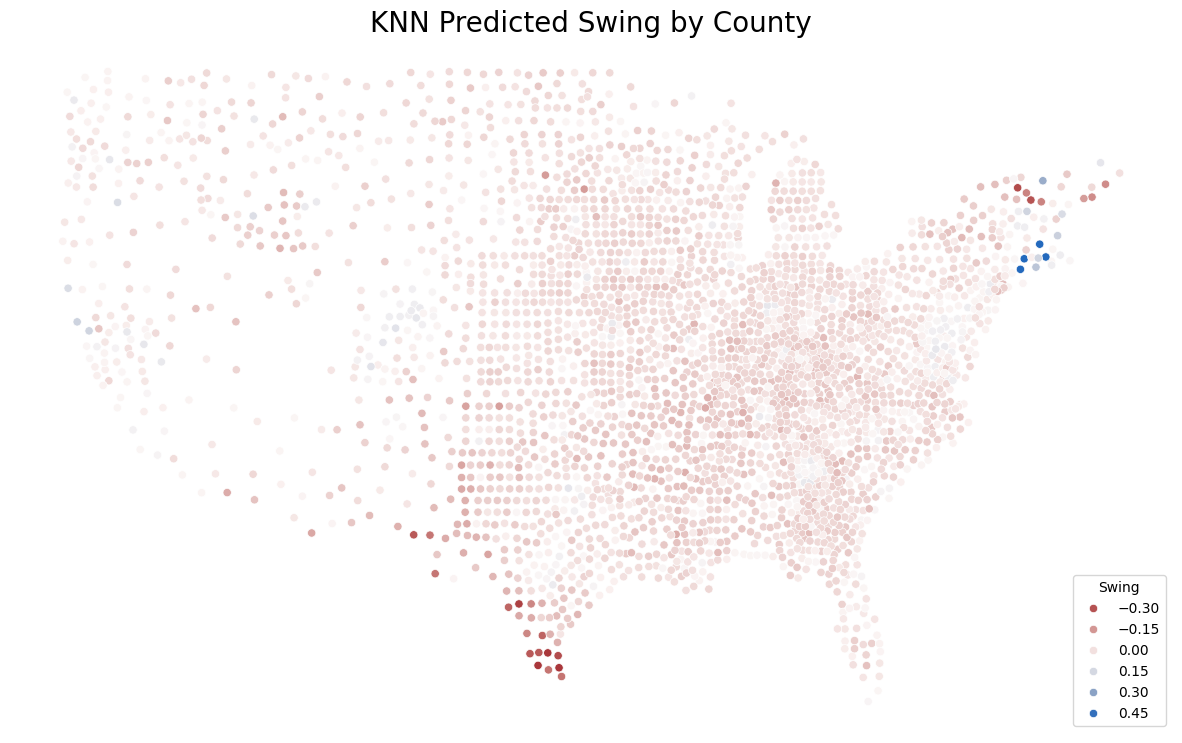

In [ ]:
continental_us = df.loc[(df["state"] != "HI") & (df["state"] != "AK")& (df["long"] != 0)]
plt.figure(figsize = (15,9))
sns.scatterplot(data = continental_us, y = "lat",x = "long", hue = "knn_preds",palette = "vlag_r")
plt.legend(title = "Swing", loc = "lower right")
plt.title("KNN Predicted Swing by County",fontsize = 20)
plt.axis("off")
#Not included in writeup

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3021 entries, 0 to 3110
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   knn_preds                  3021 non-null   float64
 1   linreg_preds               3021 non-null   float64
 2   Professional               3021 non-null   float64
 3   IncomePerCap               3021 non-null   float64
 4   Income                     3021 non-null   float64
 5   percentage20_Joe_Biden     3021 non-null   float64
 6   votes16_Donald_Trump       3021 non-null   float64
 7   Office                     3021 non-null   float64
 8   Asian                      3021 non-null   float64
 9   votes20_Donald_Trump       3021 non-null   float64
 10  lat                        3021 non-null   float64
 11  total_votes16              3021 non-null   float64
 12  Production                 3021 non-null   float64
 13  Construction               3021 non-null   float64
 1

In [ ]:
#Neural Networks
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X)
xt = torch.tensor(scaled_x, dtype = torch.float32)
yt = torch.tensor(y.values, dtype = torch.float32)
linreg_nn = nn.Sequential(nn.Linear(in_features = vars_len, out_features = 300),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(in_features = 300, out_features = 150),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(in_features = 150, out_features = 1))
loss_fn = nn.MSELoss()
optimizer = optim.SGD(linreg_nn.parameters(), lr = 0.001)

In [ ]:
losses = []
for epoch in range(1000):
  yhat = linreg_nn(xt.unsqueeze(1))
  loss = loss_fn(yt.unsqueeze(1), yhat)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f"Epoch {epoch}, Loss {loss}")
  losses.append(loss.item())

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3021, 1, 1])) that is different to the input size (torch.Size([3021, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss 0.019619209691882133
Epoch 100, Loss 0.010620126500725746
Epoch 200, Loss 0.009686221368610859
Epoch 300, Loss 0.009439361281692982
Epoch 400, Loss 0.009148172102868557
Epoch 500, Loss 0.008602752350270748
Epoch 600, Loss 0.008643909357488155
Epoch 700, Loss 0.00785667635500431
Epoch 800, Loss 0.008192893117666245
Epoch 900, Loss 0.007866969332098961


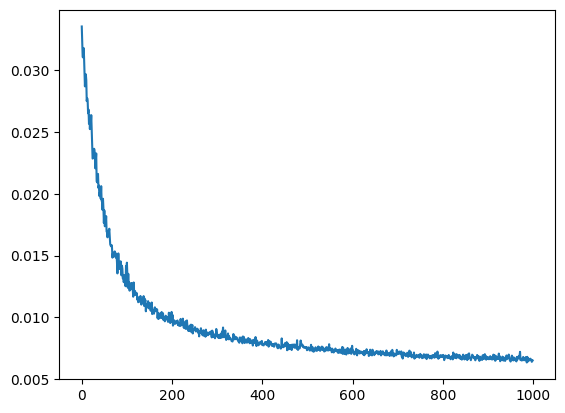

In [ ]:
plt.plot(losses)

In [ ]:
ypreds = yhat.detach().numpy()

In [ ]:
df["nn_preds"] = ypreds.squeeze().tolist()

In [ ]:
df["nn_preds"]

,nn_preds
0,-0.069345
1,-0.015284
2,-0.040942
3,0.036889
4,-0.035560
...,...
3106,0.015912
3107,-0.017383
3108,-0.078218
3109,0.047034


In [ ]:
nn_preds = df["nn_preds"]
print(df["trump_swing"].mean())
print(df["nn_preds"].mean())
print(f"swing min: {df['trump_swing'].min()}")
print(f"swing max: {df['trump_swing'].max()}")
print(f"NN min: {df['nn_preds'].min()}")
print(f"NN max: {df['nn_preds'].max()}")
print(f"NN MSE: {mse(y,nn_preds)}")
print(f"Baseline: {mse(y, zeroes_list)}")

-0.0013518702416418411
-0.003174468116709597
swing min: -0.5
swing max: 0.5
NN min: -0.4100947678089142
NN max: 0.3359430730342865
NN MSE: 0.006255117369859717
Baseline: 0.0036586249586229727


(np.float64(-126.98373933799999),
 np.float64(-64.80167790200001),
 np.float64(24.0283850785),
 np.float64(50.002941411500004))

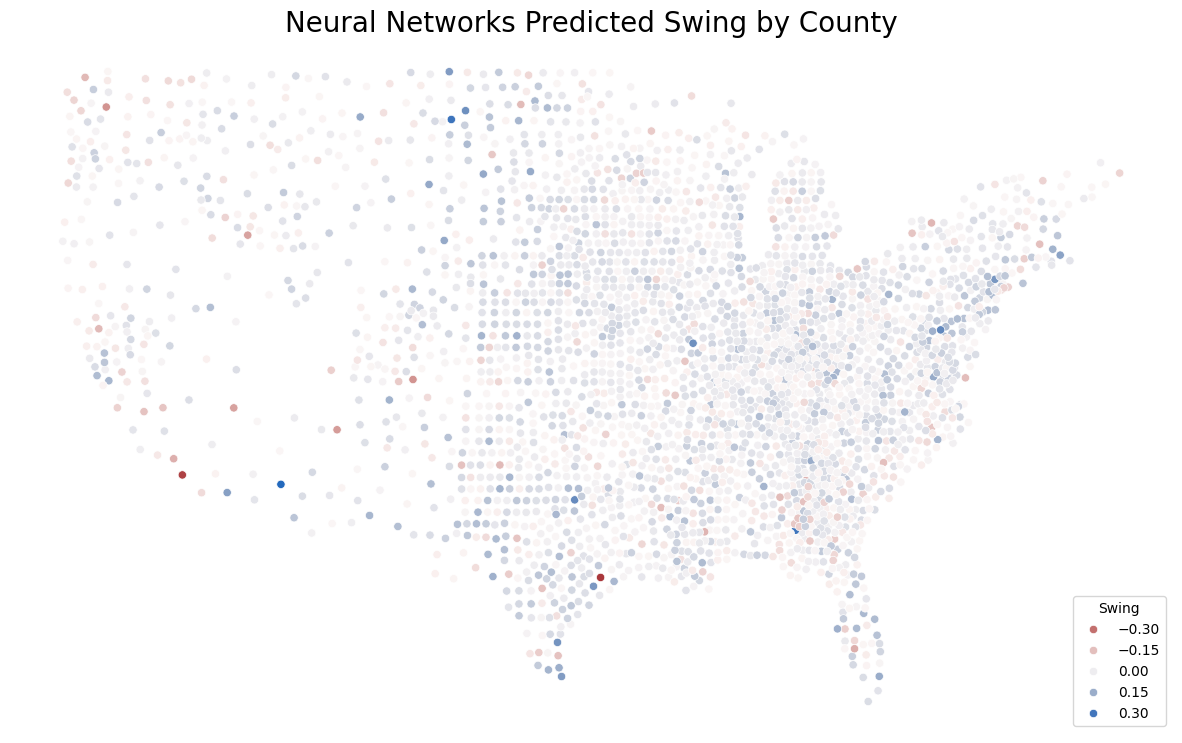

In [ ]:
continental_us = df.loc[(df["state"] != "HI") & (df["state"] != "AK")& (df["long"] != 0)]
plt.figure(figsize = (15,9))
sns.scatterplot(data = continental_us, y = "lat",x = "long", hue = "nn_preds",palette = "vlag_r")
plt.legend(title = "Swing", loc = "lower right")
plt.title("Neural Networks Predicted Swing by County",fontsize = 20)
plt.axis("off")
#Not included in writeup